In [8]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [11]:
filename = "../data/pairs_box_L205n2500TNG.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
pair_data = {}
for k in keys:
    pair_data[k] = f[k][...]
print(keys)
f.close()

['halo_mass_A', 'halo_mass_B', 'halo_mass_G', 'pos_A', 'pos_B', 'pos_G', 'stellar_mass_A', 'stellar_mass_B', 'stellar_mass_G', 'vel_A', 'vel_B', 'vel_G', 'vmax_A', 'vmax_B', 'vmax_G']


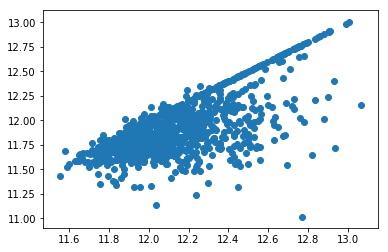

In [14]:
plt.scatter(np.log10(pair_data['halo_mass_A'])+10, np.log10(pair_data['halo_mass_B'])+10)